# Notebook Imports

In [22]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import random

# Load Books Review Data

In [23]:
file_name = 'C:/Users/Akhila chowdary/My Projects - ML/Amazon Review Sentiment Analysis/Books_small_10000.json'

### Creating Data Class

In [24]:
## Creating sentiment class
class Sentiment:
    NEGATIVE = 'NEGATIVE'
    POSITIVE = 'POSITIVE'

##Creating Review class which extracts review text, review score from each line of the input file
class Review:
    def __init__(self,text,score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <=3:
            return Sentiment.NEGATIVE
        else: #if score is 4 or 5
            return Sentiment.POSITIVE
        
##Creating Review container class which changes score to positive or negative class and also evenly distributes the unbalanced data passed into it
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
        
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)
        
        
        

In [25]:
## Creating 'reviews' list to hold the values of review text and Overall score
reviews = []

with open(file_name) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'],review['overall']))

In [26]:
reviews[5].sentiment

'POSITIVE'

In [27]:
len(reviews)

10000

# Prep Data

In [28]:
##splitting training and testing data for classification model
train,test = train_test_split(reviews,test_size=0.33, random_state=42)

train_unb_cont = ReviewContainer(train)
test_unb_cont = ReviewContainer(test)

print('Training split of unbalanced dataset:', len(train_unb_cont.reviews))
print('Training split of unbalanced dataset:', len(test_unb_cont.reviews))

Training split of unbalanced dataset: 6700
Training split of unbalanced dataset: 3300


In [31]:
## Creating x and y varibales for holding the balanced and unbalanced training and testing data set

x_unb_train = train_unb_cont.get_text()
y_unb_train = train_unb_cont.get_sentiment()
x_unb_test = test_unb_cont.get_text()
y_unb_test = test_unb_cont.get_sentiment()


### Bag of words vectorization

In [33]:
## using TfidfVectorizer to bag of words

vect = TfidfVectorizer()

x_unb_train_counts = vect.fit_transform(x_unb_train)
x_unb_test_counts = vect.transform(x_unb_test)

# Classification Model for Unbalanced Data Set

### Support Vector Machine(svm),  Decision Tree, K Nearest Neighbors, Logistic Regression

In [39]:
##fitting the unbalanced data with 4 different classification models

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

clf_svm = svm.SVC(kernel = 'linear')
clf_dec = DecisionTreeClassifier()
clf_knn = KNeighborsClassifier()
clf_log = LogisticRegression()


clf_svm.fit(x_unb_train_counts,y_unb_train)
clf_dec.fit(x_unb_train_counts,y_unb_train)
clf_knn.fit(x_unb_train_counts,y_unb_train)
clf_log.fit(x_unb_train_counts,y_unb_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Evaluation of Unbalanced Data Model

In [40]:
##Accuracy of all the models are more than 80%

print("Accuracy of unbalanced SVM Model:",round(clf_svm.score(x_unb_test_counts, y_unb_test),2))
print("Accuracy of unbalanced Decision Tree Model:", round(clf_dec.score(x_unb_test_counts, y_unb_test),2))
print("Accuracy of unbalanced KNN Model:",round(clf_knn.score(x_unb_test_counts, y_unb_test),2))
print("Accuracy of unbalanced Logistic Regression Model:",round(clf_log.score(x_unb_test_counts, y_unb_test),2))

Accuracy of unbalanced SVM Model: 0.88
Accuracy of unbalanced Decision Tree Model: 0.79
Accuracy of unbalanced KNN Model: 0.85
Accuracy of unbalanced Logistic Regression Model: 0.87


In [41]:
##The low f1score of negatvie values indicate that, the training dataset contains more number of positive values than negative values

print("f1 Score of unbalanced SVM:",f1_score(y_unb_test, clf_svm.predict(x_unb_test_counts), average = None, labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]))
print("f1 Score of unbalanced Decision Tree:",f1_score(y_unb_test, clf_dec.predict(x_unb_test_counts), average = None, labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]))
print("f1 Score of unbalancedd KNN:",f1_score(y_unb_test, clf_knn.predict(x_unb_test_counts), average = None, labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]))
print("f1 Score of unbalanced Logistic regression:",f1_score(y_unb_test, clf_log.predict(x_unb_test_counts), average = None, labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]))

f1 Score of unbalanced SVM: [0.93479753 0.50777202]
f1 Score of unbalanced Decision Tree: [0.87720562 0.34799235]
f1 Score of unbalancedd KNN: [0.91436324 0.28165007]
f1 Score of unbalanced Logistic regression: [0.92626961 0.35066865]


In [15]:
##creating probability score for plotting recall vs precision graph

y_unb_pred_svm = clf_svm.decision_function(x_unb_test_counts)
y_unb_pred_dec = clf_dec.predict_proba(x_unb_test_counts)
y_unb_pred_knn = clf_knn.predict_proba(x_unb_test_counts)
y_unb_pred_logistic = clf_log.decision_function(x_unb_test_counts)

In [16]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

unb_test = lb.fit_transform(y_unb_test)

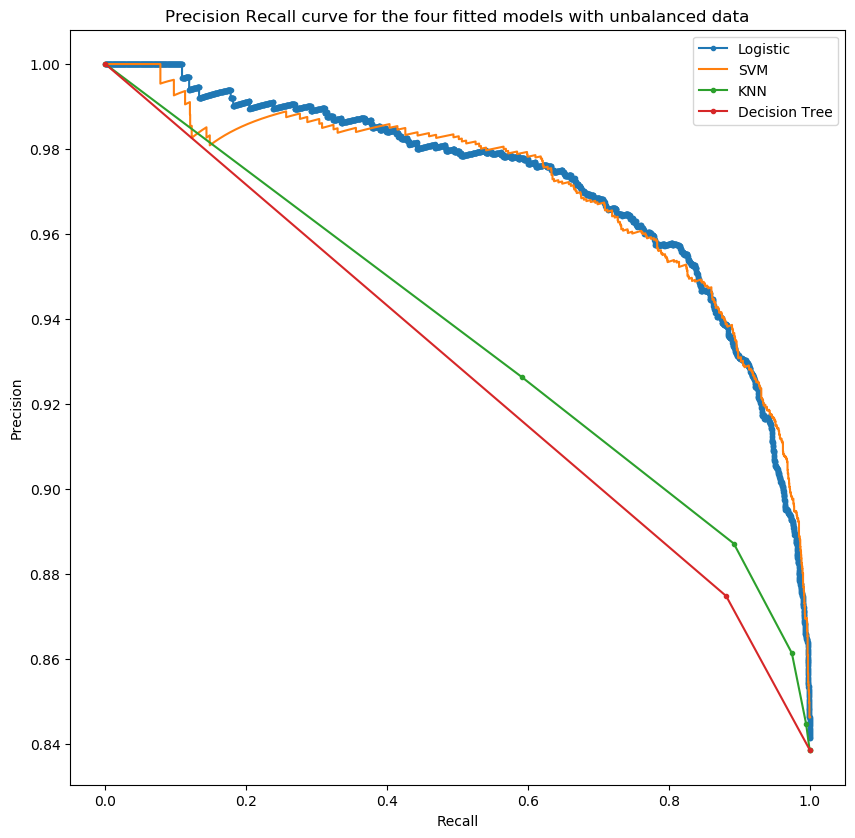

In [17]:
from sklearn.metrics import precision_recall_curve

lr_precision, lr_recall, _ = precision_recall_curve(unb_test, y_unb_pred_logistic)

svm_precision, svm_recall, _ = precision_recall_curve(unb_test, y_unb_pred_svm)

dec_precision, dec_recall, _ = precision_recall_curve(unb_test, y_unb_pred_dec[:,1])

knn_precision, knn_recall, _ = precision_recall_curve(unb_test, y_unb_pred_knn[:,1])


plt.figure(figsize=(10, 10), dpi=100)
plt.title('Precision Recall curve for the four fitted models with unbalanced data')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.plot(svm_recall, svm_precision, marker=' ', label='SVM')
plt.plot(knn_recall,knn_precision, marker='.', label='KNN')
plt.plot(dec_recall, dec_precision, marker='.', label='Decision Tree')


plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()

plt.show()

##### Conclusion 1: From above shown analysis, we can understand that the number of positives are much higher compared to Negatives in the dataset. Due to which the model is prone to predict 'False positives'.
##### So, there is need for improving model by balancing the dataset, where postiives to negative instances should be in the ratio of 1:1

# Balancing the Training Data Set

In [30]:
train, test = train_test_split(reviews, test_size = 0.22, random_state = 100)

train_b_cont = ReviewContainer(train)
test_container = ReviewContainer(test)

# we are training the system that reviews which had rating of 3 and
# above are majorly positive and we train words in data set in order to get the sentiment of review

train_b_cont.evenly_distribute()

x_b_train = train_b_cont.get_text()
y_b_train = train_b_cont.get_sentiment()

x_test = test_container.get_text()
y_test =  test_container.get_sentiment()

print(y_b_train.count(Sentiment.POSITIVE))
print(y_b_train.count(Sentiment.NEGATIVE))

# here the number of positive and negative reviews is that of same as we used the 'evenly_distribute()' function.

x_b_train_vector = vect.fit_transform(x_b_train)
x_test_vector = vect.transform(x_test)

1243
1243


# Classification Model for Balanced Data Set

### Support Vector Machine(svm),  Decision Tree, K Nearest Neighbors, Logistic Regression

In [42]:
##fitting the balanced data with 4 different classification models

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

clf_svm = svm.SVC(kernel = 'linear')
clf_dec = DecisionTreeClassifier()
clf_knn = KNeighborsClassifier()
clf_log = LogisticRegression()


clf_svm.fit(x_b_train_vector,y_b_train)
clf_dec.fit(x_b_train_vector,y_b_train)
clf_knn.fit(x_b_train_vector,y_b_train)
clf_log.fit(x_b_train_vector,y_b_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Evaluation of Balanced Data Model

In [43]:
##the accuracy value of the balanced classfication model got reduced

print("Accuracy of balanced SVM Model:",round(clf_svm.score(x_test_vector, y_test),2))
print("Accuracy of balanced Decision Tree Model:", round(clf_dec.score(x_test_vector, y_test),2))
print("Accuracy of balanced KNN Model:",round(clf_knn.score(x_test_vector, y_test),2))
print("Accuracy of balanced Logistic Regression Model:",round(clf_log.score(x_test_vector, y_test),2))

Accuracy of balanced SVM Model: 0.79
Accuracy of balanced Decision Tree Model: 0.63
Accuracy of balanced KNN Model: 0.76
Accuracy of balanced Logistic Regression Model: 0.79


In [44]:
##unlike the accuracy score, the f1 score is now evenly distributed.The true positives and true negatives has good precision and recall.

print("f1 Score of unbalanced SVM:",f1_score(y_test, clf_svm.predict(x_test_vector), average = None, labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]))
print("f1 Score of unbalanced Decision Tree:",f1_score(y_test, clf_dec.predict(x_test_vector), average = None, labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]))
print("f1 Score of unbalancedd KNN:",f1_score(y_test, clf_knn.predict(x_test_vector), average = None, labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]))
print("f1 Score of unbalanced Logistic regression:",f1_score(y_test, clf_log.predict(x_test_vector), average = None, labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]))

f1 Score of unbalanced SVM: [0.85817308 0.55970149]
f1 Score of unbalanced Decision Tree: [0.73988439 0.37013997]
f1 Score of unbalancedd KNN: [0.84653322 0.44491081]
f1 Score of unbalanced Logistic regression: [0.86158445 0.56113744]


In [45]:
##finding prediction probability values for each model
y_pred_svm = clf_svm.decision_function(x_test_vector)
y_pred_dec = clf_dec.predict_proba(x_test_vector)
y_pred_knn = clf_knn.predict_proba(x_test_vector)
y_pred_logistic = clf_log.decision_function(x_test_vector)

In [46]:
##converting 'Positive' to '1' and 'Negative' to '0'

from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

b_test = lb.fit_transform(y_test)

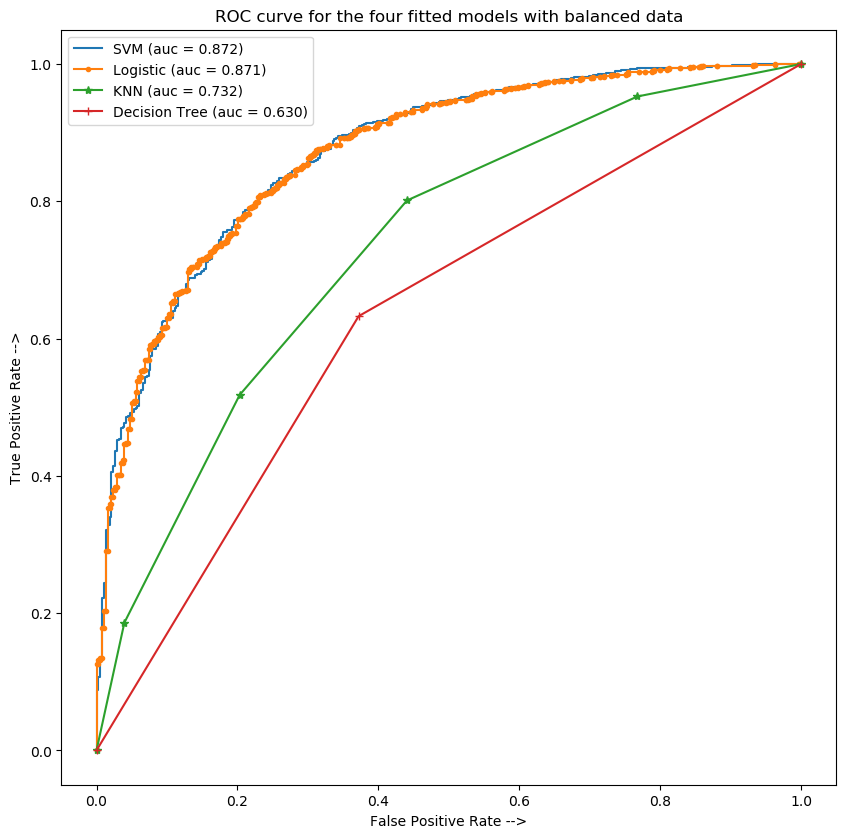

In [48]:
##plotting ROC curve for 4 models

from sklearn.metrics import roc_curve, auc

logistic_fpr, logistic_tpr, threshold = roc_curve(b_test,y_pred_logistic)
auc_logistic = auc(logistic_fpr, logistic_tpr)

svm_fpr, svm_tpr, threshold = roc_curve(b_test,y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

dec_fpr, dec_tpr, threshold = roc_curve(b_test,y_pred_dec[:,1])
auc_dec = auc(dec_fpr, dec_tpr)

knn_fpr, knn_tpr, threshold = roc_curve(b_test,y_pred_knn[:,1])
auc_knn = auc(knn_fpr, knn_tpr)

plt.figure(figsize=(10, 10), dpi=100)
plt.title('ROC curve for the four fitted models with balanced data')
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(knn_fpr, knn_tpr, marker='*', label='KNN (auc = %0.3f)' % auc_knn)
plt.plot(dec_fpr, dec_tpr, marker='+', label='Decision Tree (auc = %0.3f)' % auc_dec)


plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

# Hyperparameter Tuning - Grid Search

In [53]:
##finding the best SVM model with GridSeach method 

from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(x_b_train_vector,y_b_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [58]:
print(clf.score(x_test_vector,y_test))

##the maximum precision that can be obtained from svm model is 79.6% 

0.7963636363636364


# Saving Model

In [59]:
import pickle
with open('sentiment_analysis_amazon_reviews.pickle','wb') as f:
    pickle.dump(clf,f)

# Loading Model

In [60]:
with open('sentiment_analysis_amazon_reviews.pickle', 'rb') as f:
    loaded_clf = pickle.load(f)

# Testing Model with new data

In [61]:
test_set = ['very fun', "bad book do not buy", 'horrible waste of time','This book is ']
new_test = vect.transform(test_set)

loaded_clf.predict(new_test)

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE'], dtype='<U8')

In [62]:
new_data = pd.read_csv('Reviews.csv',encoding='mac_roman')

In [63]:
new_data.shape

(999, 1)

In [64]:
new_data.ReviewContent.head()

0    Good. It IS a page turner. You can read this b...
1    There are no words for how much I loathed this...
2    I think I would ordinarily cut this book more ...
3    Three disjointed characters for whom it's hard...
4    Was snookered into this novel as it was compar...
Name: ReviewContent, dtype: object

In [65]:
new_test = vect.transform(new_data.ReviewContent)

result = loaded_clf.predict(new_test)

In [66]:
print(new_data.ReviewContent[544],result[544])
print(new_data.ReviewContent[227],result[227])
print(new_data.ReviewContent[104],result[104])
print(new_data.ReviewContent[742],result[742])
print(new_data.ReviewContent[897],result[897])
print(new_data.ReviewContent[6],result[6])

A good read.  I enjoyed it. POSITIVE
Interesting but one of those books where you want to choke the main character. NEGATIVE
"My mother used to tell me that I had an overactive imagination..."And with that, Rachel the narrator certainly becomes one of the most unreliable narrators I've ever had the pleasure of reading. There are actually several points of view in 'The Girl on the Train' but Rachel is the main narrator. A sad sack of a woman, she has been recently divorced, fired from her job in London and is losing a nasty battle with the bottle. Because she is often drunk, nothing she says or recalls is trustworthy.I needed a break from my usual contemporary romances and this thriller kept me glued to my Kindle! Rachel sees a "prefect couple" from the train every day, and she concocts an elaborate fantasy life for them. Surely they must live a perfect life! Unlike her, they seem to live a charmed life, sitting in their pretty garden every day, sipping coffee together."I donít know the

In [67]:
result

array(['NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE',
       'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE',
       'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE',
       'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE',
       'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE',
       'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE',
       'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE',
       'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE',
       'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE',
       'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE',
       'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE',
       'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE',
       'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE',
       'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE',
       'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATI

In [68]:
new_data

,ReviewContent
0,Good. It IS a page turner. You can read this b...
1,There are no words for how much I loathed this...
2,I think I would ordinarily cut this book more ...
3,Three disjointed characters for whom it's hard...
4,Was snookered into this novel as it was compar...
...,...
994,Very slow read.Too much repetition. Disappointed
995,I don't think this book is worth all the hype....
996,I've read other excellent reviewers who found ...
997,I saw this novel on the best seller list so I ...
